In [1]:
import numpy as np
import numpy.ma as ma
import numpy.linalg as linalg

import netCDF4 as nc
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

from scipy import stats
from scipy import signal
from scipy.fft import fft 
from scipy.stats.stats import pearsonr

import warnings 
warnings.filterwarnings('ignore')

C:\Users\usuario\AppData\Local\Temp\ipykernel_4588\2082327129.py:15: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
folder = 'data/'
data   = xr.open_dataset(f'{folder}Tn10p_ESP_nan.nc')

# <span style='color:darkred'>Parte 3</span>

## <span style='color:darkgreen'>1.Prueba</span>

In [3]:
# selecciono la latitud y longitud
lon = data.x
lat = data.y

In [4]:
variable = data.__xarray_dataarray_variable__

Text(0.5, 0.98, 'Porcentaje de noches frías definiendo el percentil con el primer periodo')

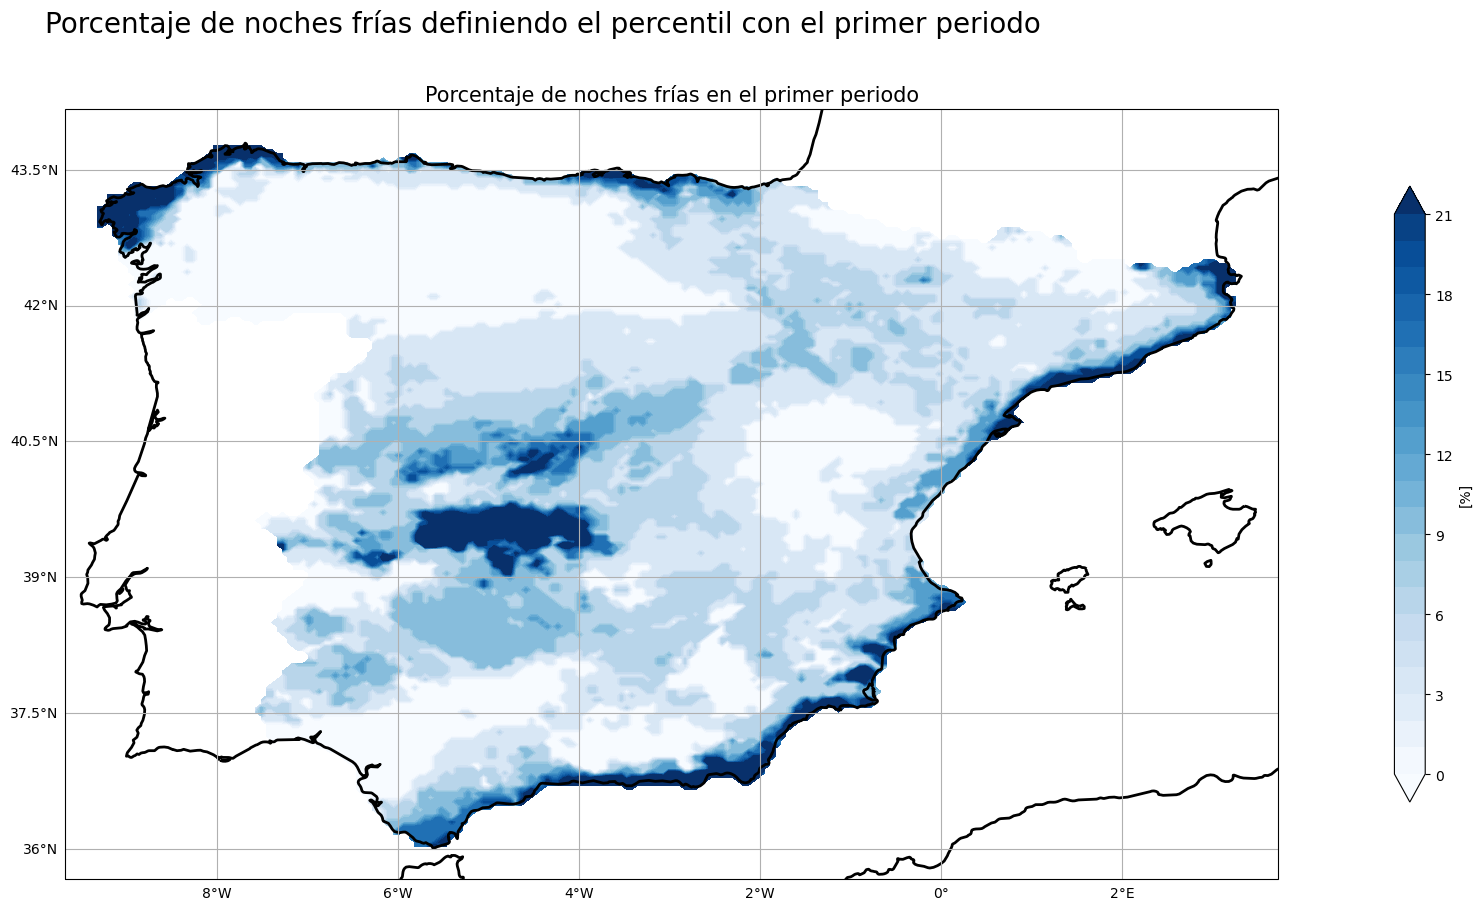

In [5]:
# selecciono un dia en especifico
perc_1_mean = variable.sel(time = '1901-01-01')

# Representamos el porcentaje para cada punto de la malla de datos
fig = plt.figure(figsize=(30,10), tight_layout=False) 
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())
cbarticks = np.arange(0,22,1)

gl = ax1.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top   = False
 
cmap= 'Blues'
unidades= '[%]'

im=ax1.contourf(lon, lat, perc_1_mean, cbarticks,cmap = cmap, extend='both', 
                  vmin = 0, vmax = 22)

# im2 = ax2.contourf(lon, lat, perc_2_mean, cbarticks,cmap = cmap, extend='both', 
#                    vmin = mini, vmax = maxi) 
# ax2.coastlines(linewidth = 2)
ax1.coastlines(linewidth = 2)
fig.colorbar(im,ax=ax1,shrink=0.8, label=unidades,orientation='vertical')
# fig.colorbar(im2,ax=ax2,shrink=0.8, label=unidades,orientation='vertical')
ax1.set_title('Porcentaje de noches frías en el primer periodo',fontsize=15)
# ax2.set_title('Porcentaje de noches frías en el segundo periodo',fontsize=15)
fig.suptitle('Porcentaje de noches frías definiendo el percentil con el primer periodo',
             fontsize = 20)

## <span style='color:darkgreen'>2. Calculo de la matriz de covarianza</span>

In [6]:
# la matriz de covarianza la cual multiplicamos por
# un índice debe estar estandarizada

In [7]:
# cogemos primavera porque fue donde conseguimos la mayor variabilidad
def season(Z,e1,e2,nyrs):
# para que funcione los datos Z tienen que estar con dimensiones nyrs,12,ns
# e1 y e2 son los meses inicial y final de las estaciones
# e1=2; e2=4 ; esta='MAM';
# e1=5; e2=7 ; esta='JJA';
# e1=6; e2=8 ; esta='JAS';
# e1=8; e2=10; esta='SON';
# e1=11;e2=1; esta='DJF';
# e1=10;e2=1; esta='NDJF';
   
    if e1==11:
        Zs1= Z[:-1,e1,:]
        Zs2= Z[1:,:e2,:].mean(1)
        n1=1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    elif e1>e2:
        Zs1= Z[:-1,e1:11,:].mean(1)
        Zs2= Z[1:,:e2,:].mean(1)
        n1=12-e1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    else:
        Zs = Z[:, e1:e2, :].mean(1)

    return Zs ,nyrs

In [8]:
# dimesiones y las guardos
ntime, nlat, nlon = variable.shape

# hago un reshape para poder usar la función season
variable_reshaped = np.reshape(variable, (int(ntime/12), 12, nlat*nlon))

# agrupo por meses en primavera
tn10_primavera = season(np.asarray(variable_reshaped), 2, 4, ntime/12)[0]
# elijo el [0] porque devuelve otro dato que no se usa